# Aplicación 2: reconocimiento de rostros

Comenzaremos, antes que nada, importando algunas herramientas útiles:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Ejemplo: Reconocimiento de rostros

Veremos un ejemplo, donde usaremos máquinas de vectores soporte (SVM) aplicadas al problema de reconocimiento facial. Usaremos los rostros etiquetados disponibles en el "Wild dataset", el cual consiste de fotos recolectadas de diversas figuras públicas.
Scikit-Learn dispone de una herramienta (un "fetcher") que recupera este conjunto de datos

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [3]:
print(faces.data.shape)

(1348, 2914)


Mostremos algunos de estos rostros para ver con que estamos trabajando:

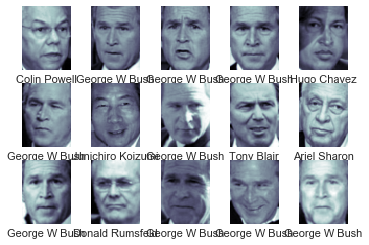

In [4]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagen contiene [62 × 47] (casi 3.000) píxeles.
Podríamos proceder simplemente utilizando cada valor de píxel como característica, pero a menudo es más efectivo realizar algún tipo de preprocesamiento para extraer características más significativas; aquí utilizaremos un análisis de componentes principales (PCA) para extraer 150 componentes fundamentales para alimentar a nuestro clasificador SVM.
Podemos hacer esto de manera más sencilla conectando el preprocesador (PCA) y el clasificador (SVM) en un único pipeline:

In [5]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)
svc = SVC(C=5, kernel='rbf', gamma=0.001, class_weight='balanced')
model = make_pipeline(pca, svc)

A los fines de evaluar las predicciones de nuestro clasificador, dividiremos los datos en un conjunto de entrenamiento y uno de prueba:

In [6]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Luego, entrenamos el modelo y realizamos las predicciones:

In [7]:
model.fit(Xtrain, ytrain)
yfit = model.predict(Xtest)

Echemos un vistazo a algunas de las imágenes de prueba junto con los valores predichos:

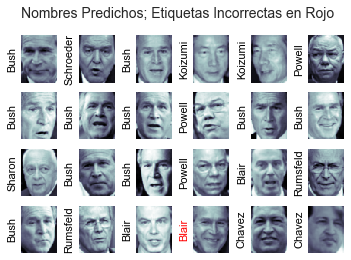

In [8]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Nombres Predichos; Etiquetas Incorrectas en Rojo', size=14);

De esta pequeña muestra, nuestro clasificador etiquetó erróneamente solo un rostro (el de Bush en la fila de más abajo fue etiquetado como Blair).

Podemos tener una mejor idea del rendimiento general de nuestro clasificador utilizando el informe de clasificación, que enumera las estadísticas de recuperación etiqueta por etiqueta:

In [9]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.82      0.88      0.85        68
  Donald Rumsfeld       0.76      0.84      0.80        31
    George W Bush       0.97      0.81      0.88       126
Gerhard Schroeder       0.69      0.87      0.77        23
      Hugo Chavez       0.88      0.70      0.78        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.89      0.98      0.93        42

      avg / total       0.87      0.85      0.86       337



También podríamos mostrar la matriz de confusión entre estas clases:

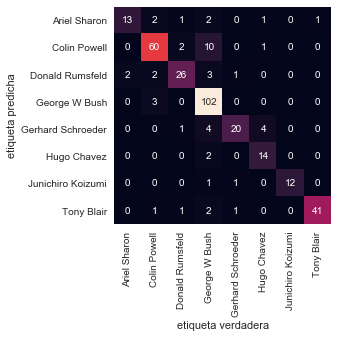

In [10]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('etiqueta verdadera')
plt.ylabel('etiqueta predicha');

Esto nos ayuda a tener una idea de cuales son las etiquetas que es probable que el clasificador confunda.

Para una tarea de reconocimiento facial en el mundo real, en la cual las fotos no vienen recortadas en buenas cuadrículas, la única diferencia en el esquema de clasificación facial es la selección de características: necesitarías usar un algoritmo más sofisticado para encontrar las caras, y extraer características que son independientes de la "pixelilación". Para este tipo de aplicación, una buena opción es hacer uso de [OpenCV](http://opencv.org), que, entre otras cosas, incluye implementaciones pre-entrenadas de las herramientas de extracción de características más efectivas en la actualidad para imágenes, en general, y rostros en particular.